# **ACO: Classical Ant Colony Optimization**

ACO algorithm for the QAP written based on our paper and inspired by the original article by *Blum and Dorigo (2004)*, summarized in Algorithm 3.

The input parameters used in the paper for the algorithm are similar to those used for QACO, with `βe = 0.4` for more random exploration, `maxIter = 50` and `convergenceCondition = 20` are decreased because the fit is shifted to bigger `n`, while the pheromone evaporation value `ρ = 0.1` is twice that in the original ACO paper.

To completely mimic the QACO implementation, we launched only one ant per ACO iteration.


## **Problem representation**

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

# ACO Parameters
rho = 0.1                  # Pheromone evaporation
beta_O = 0.4               # Random exploration probability
maxIter = 40               # Maximum number of iterations
converCondition = 20       # Convergence condition
n = 4                      # Problem matrix size
minFactor = 2              # Multiplicative factor for calculating fitness offset
optimization_mode = 'max'  # Optimization mode: 'max' for maximization, 'min' for minimization
problem_matrix = 4         # Choice of problem matrix (1, 2, 3, 4 or 5)


**Definition of the problem matrix M**\
`M[i,j]` = Cost/Benefit of traversing the edge from node i to node j


In [2]:
import pandas as pd

def load_trial_matrix(problem_matrix):
    """Loads matrix M and solution vector X_th from CSV file"""
    file_path = f"../Trial_matrices/M{problem_matrix}.csv"
    data = pd.read_csv(file_path, header=None)
    
    M = data.iloc[:4, :].values  # First 4 rows = matrix
    X_th = data.iloc[4, :].values  # Last row = solution vector
    
    return M, X_th


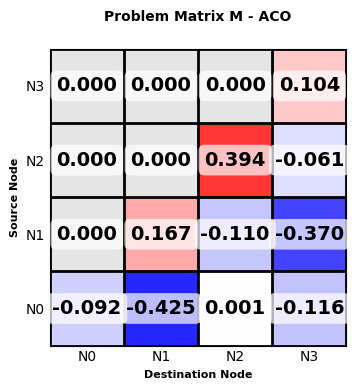

In [3]:
# Visualization of matrix M
def plot_matrix(matrix, title="M Matrix Visualization"):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Create a custom color map
    # Negative values -> blue, positive values -> red
    colors = []
    for i in range(matrix.shape[0]):
        color_row = []
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                # Red intensity based on value
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scale intensity
                color_row.append([1, 1-intensity, 1-intensity])  # Red with gradations
            elif matrix[i, j] < 0:
                # Blue intensity based on value
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scale intensity
                color_row.append([1-intensity, 1-intensity, 1])  # Blue with gradations
            else:
                color_row.append([0.9, 0.9, 0.9])  # Light gray for zero
        colors.append(color_row)
    
    # Draw the matrix as image
    im = ax.imshow(colors, aspect='equal')
    
    # Add numerical values in cells
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Choose text color based on background
            text_color = 'black'
            
            # Format number for better readability
            value_text = f'{matrix[i, j]:.3f}'
            
            ax.text(j, i, value_text, 
                   ha='center', va='center', 
                   color=text_color, 
                   fontsize=14, 
                   fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", 
                           facecolor='white', 
                           alpha=0.7,
                           edgecolor='none'))
    
    # Customize grid and labels
    ax.set_xlim(-0.5, matrix.shape[1]-0.5)
    ax.set_ylim(-0.5, matrix.shape[0]-0.5)
    
    # Add elegant gridlines
    for i in range(matrix.shape[0] + 1):
        ax.axhline(i - 0.5, color='black', linewidth=2)
    for j in range(matrix.shape[1] + 1):
        ax.axvline(j - 0.5, color='black', linewidth=2)
    
    # Axis labels
    ax.set_xticks(range(matrix.shape[1]))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels([f'N{i}' for i in range(matrix.shape[1])])
    ax.set_yticklabels([f'N{i}' for i in range(matrix.shape[0])])
    
    # Title and labels
    ax.set_title(title, fontsize=10, fontweight='bold', pad=20)
    ax.set_xlabel('Destination Node', fontsize=8, fontweight='bold')
    ax.set_ylabel('Source Node', fontsize=8, fontweight='bold')
    
    # Remove tick marks for cleaner look
    ax.tick_params(length=0)
    
    plt.tight_layout()
    plt.show()
    
# Apply visualization to matrix M
M, X_th = load_trial_matrix(problem_matrix)
plot_matrix(M, "Problem Matrix M - ACO")


**QAP: Quadratic Assignment Problem**\
I need to find the vector X that optimizes the fitness function `X @ M @ X.T`, which in this case maximizes/minimizes the sum of selected elements of M.


## **1. Exploration**


The vector X is a binary variable vector that tells me which nodes the ant visits. It is generated through an algorithm that is partly completely random (to always search new paths) and partly uses pheromone preferences, according to the `beta_O` coefficient.


In [4]:
def construct_solution(n, ant_position, tau, beta):
    """Constructs a solution for an ant"""
    visited = set([ant_position]) # Create a set containing the current ant position
    path = [ant_position] # Initialize path with the ant's starting position
    
    for k in range(n):
        candidates = [i for i in range(1, n + 2) if i not in visited] # n + 2 to account for n + 1
        # Create list of all available nodes the ant can still visit
        if not candidates:
                break
    
        if random.random() < beta:  
            # Random exploration
            next_position = random.choice(candidates)
        else:
            # Exploitation based on pheromones   
            values = [tau[ant_position, i] for i in candidates]
            probs = np.array(values) # Probability vector based on pheromones
            probs_sum = probs.sum() # Total sum of probabilities
        
            if probs_sum == 0: # No pheromone, random exploration
                probs = (np.ones(len(candidates)))  /  len(candidates) # Uniform probability
            else:
                probs = probs / probs_sum
                
            next_position = random.choices(candidates, weights=probs)[0] # Weighted choice

        ant_position = next_position # Update ant position
        visited.add(ant_position) # Add new position to visited set
        path.append(ant_position) # Add new position to path
        
        if ant_position == n + 1:
            break
        
    return path # Return complete ant path

def generate_solution_vector(n, path):
    """Generates the solution vector X"""
    X = np.zeros(n)
    for node in path:
        if 1 <= node <= n:
            X[node-1] = 1 # Set binary variables for visited nodes
    return X


## **2. Solution Quality**


Problem: some elements of M are negative, so the sum could be negative\
`epsilon = 1e-6`: Small positive value to avoid zero

- Negative case: The offset is large enough to guarantee that even the worst possible result becomes positive
- Positive case: The offset is minimal to avoid significantly altering values
- Epsilon always present: Avoids exact zero value (which would cause division by zero in rho/fitness)


In [5]:
def calculate_fitness(X, M):
    """Calculates fitness with offset to avoid negative values"""
    raw_fitness = X @ M @ X.T # Calculation of actual fitness
    epsilon = 1e-6
    min_value = np.min(M)
    
    if min_value < 0:
       offset = abs(minFactor*min_value) + epsilon # Offset to avoid negatives
    else:
       offset = epsilon

    return (raw_fitness + offset), raw_fitness


## **3. Pheromones**


In ACO algorithms, the probabilistic model is called the **pheromone model**. The pheromone model consists of a set of model parameters, called **pheromone trace parameters**. Pheromone trace parameters have values, called **pheromone values**. During execution, ACO algorithms seek to update pheromone values such that the probability of generating high-quality solutions increases over time.

Pheromones **are on edges between nodes**, while in QAP they are on nodes.
- Pheromones are stored in the matrix `tau[a, b]`
- Each cell `tau[a, b]` represents the amount of pheromone on the edge from node `a` to node `b`


In [6]:
# Initialize pheromone matrix
def initialize_pheromones(n):
    """Initializes the pheromone matrix to zero"""
    return np.zeros((n+2, n+2)) # +2 to include start and end nodes

def update_pheromones(tau, path, fitness, rho, n, optimization_mode):
    """Updates pheromone values"""
    # Evaporation on all edges
    for i in range(n):
        for j in range(n):
            tau[i, j] = (1 - rho) * tau[i, j]
    
    # Deposit proportional to fitness on both sides of the matrix (undirected graph)  
    for i in range(len(path)-1):
        a, b = path[i], path[i+1] # a and b are assigned the node numbers of a certain edge a->b
        # So the entry in matrix tau[a, b] represents the amount of pheromone on the edge from node a to node b
        if optimization_mode == 'min':
            tau[a, b] += (rho / fitness)
            tau[b, a] += (rho / fitness)
            # Deposit inversely proportional to fitness on both sides (undirected graph)
        elif optimization_mode == 'max':
            tau[a, b] += 1 - (rho / fitness)
            tau[b, a] += 1 - (rho / fitness)
        else:
            raise ValueError("Invalid optimization mode. Choose 'max' or 'min'.")
    return tau


In [7]:
def plot_pheromone_matrix(tau, title="Pheromone Matrix - Visualization"):
    """
    Visualizes the pheromone matrix with pink shades
    - Pink intensity proportional to pheromone value
    - Numerical values in cells
    - Elegant grid
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Normalize values for color map
    tau_max = np.max(tau)
    tau_min = np.min(tau)
    
    if tau_max == tau_min:  # All values are equal
        normalized_tau = np.zeros_like(tau)
    else:
        normalized_tau = (tau - tau_min) / (tau_max - tau_min)
    
    # Create pink color map
    colors = []
    for i in range(tau.shape[0]):
        color_row = []
        for j in range(tau.shape[1]):
            intensity = normalized_tau[i, j]
            if tau[i, j] == 0:
                # White for zero values
                color_row.append([1.0, 1.0, 1.0])
            else:
                # Pink shades: more intense = darker
                # RGB for pink: (1, pink_component, pink_component)
                pink_component = 1 - (intensity * 0.7)  # From 1 (white) to 0.3 (dark pink)
                color_row.append([1.0, pink_component, pink_component])
        colors.append(color_row)
    
    # Draw the matrix
    im = ax.imshow(colors, aspect='equal')
    
    # Add numerical values in cells
    for i in range(tau.shape[0]):
        for j in range(tau.shape[1]):
            text_color = 'black'
            
            # Format number
            if tau[i, j] == 0:
                value_text = '0'
            else:
                value_text = f'{tau[i, j]:.4f}'
            
            ax.text(j, i, value_text, 
                   ha='center', va='center', 
                   color=text_color, 
                   fontsize=6, 
                   fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", 
                           facecolor='white', 
                           alpha=0.8,
                           edgecolor='none'))
    
    # Customize grid
    ax.set_xlim(-0.5, tau.shape[1]-0.5)
    ax.set_ylim(-0.5, tau.shape[0]-0.5)
    
    # Add elegant gridlines
    for i in range(tau.shape[0] + 1):
        ax.axhline(i - 0.5, color='black', linewidth=1.5)
    for j in range(tau.shape[1] + 1):
        ax.axvline(j - 0.5, color='black', linewidth=1.5)
    
    # Axis labels
    ax.set_xticks(range(tau.shape[1]))
    ax.set_yticks(range(tau.shape[0]))
    ax.set_xticklabels([f'N{i}' for i in range(tau.shape[1])])
    ax.set_yticklabels([f'N{i}' for i in range(tau.shape[0])])
    
    # Title and labels
    ax.set_title(title, fontsize=10, fontweight='bold', pad=20)
    ax.set_xlabel('Destination Node', fontsize=8, fontweight='bold')
    ax.set_ylabel('Source Node', fontsize=8, fontweight='bold')

    
    plt.tight_layout()
    plt.show()


### **3.1 Stopping Criteria**


**From our paper**\
*In ACO, we have to define a termination condition for the algorithm to exit the iteration loop. 
When we have no prior information about a lower bound for the optimal solution, we can define 2 different conditions (p. 105 Dorigo and St ̈utzle 2004).*

1. *One can be to set a fixed maximum time or iterations the algorithm can run.   
   Using this criterion, making an infinite number of iterations will yield the correct result to the problem, as every possible path is allowed to be obtained in every iteration. This way, the probability of getting the result after infinite iterations will be 100%.*

   *Although valid, this termination criterion is not useful, as it is difficult to set the correct number of iterations a priori. Besides, the number of iterations could be set higher than necessary, lowering the efficiency of the algorithm.
2. *The other termination condition can be set to define a **convergence or stagnation condition**.*
   *This can be understood as having a situation in which no better results are found on consecutive iterations. To take this into account, we introduced a new parameter ```converCondition```. At the end of each iteration, the algorithm checks if the result is better than the best solution so far.*

## **4. ACO Algorithm**


In [8]:
def single_simulation(M, n, tau, beta_O, rho, maxIter, converCondition, optimization_mode, plot_best=True, verbose=True):
    """Runs one ACO simulation and returns best solution info."""
    best_solution = None
    best_X = None
    best_real_fitness = None
    if optimization_mode == 'max':
        best_offset_fitness = float(0)
    elif optimization_mode == 'min':
        best_offset_fitness = float('inf')
    else:
        raise ValueError("Invalid optimization mode. Choose 'max' or 'min'.")
    
    count = 1
    converged = False
    iter_count = 0
    
    # Main loop
    for j in range(maxIter):
        iter_count = j + 1
        # Beta could increase linearly with iterations
        # beta = beta_O + ((1-beta_O)/(maxIter)) * j
        beta = beta_O
        is_better = False
        
        # Solution construction
        ant_position = 0
        path = construct_solution(n, ant_position, tau, beta)
        # Generation of solution vector X
        X = generate_solution_vector(n, path)
        
        # Calculation of solution fitness with problem matrix
        offset_fitness, real_fitness = calculate_fitness(X, M)
        
        if offset_fitness <= 0:
            if verbose:
                print("!!!Error!!!\nOffset fitness not positive.")
                print("Offset fitness:", offset_fitness)
            break
        
        # Update pheromones
        tau = update_pheromones(tau, path, offset_fitness, rho, n, optimization_mode)
        # Check for better solution
        if path != [0, n + 1]: # Avoid trivial solution
            if optimization_mode == 'max':
                is_better = offset_fitness > best_offset_fitness
            elif optimization_mode == 'min':
                is_better = offset_fitness < best_offset_fitness
            if is_better:
                best_offset_fitness = offset_fitness
                best_real_fitness = real_fitness
                best_solution = path
                best_X = X.copy() # Copy of solution vector X
                count = 1
                
                if verbose:
                    print('NEW BEST SOLUTION FOUND:')
                    print(f'Best solution proposed (Iter. {j+1}): ', best_solution)
                    print(f'Solution vector X no. {j+1} generated: ', best_X)
                    print(f'Fitness of new best solution (Iter. {j+1}): ', best_real_fitness)
                # print(f'Fitness {j+1} increased with offset, used to update pheromone: ', best_offset_fitness)
                if plot_best and verbose:
                    plot_pheromone_matrix(tau, title=f"Pheromone Matrix - iteration {j+1}")
            else:
                count += 1 # Distance from best solution found
            
        # Check convergence
        # print('Distance from best solution found: ', count)
        if count >= converCondition:
            if verbose:
                print(f"Convergence reached after {j+1} iterations.")
            converged = True
            break
        if j == maxIter - 1:
            if verbose:
                print("--------------------------------")
                print(f"MAXIMUM NUMBER OF ITERATIONS ({maxIter}) REACHED WITHOUT CONVERGENCE.\n Convergence loop interrupted at {count} iterations\n")
                print(f"Best solution found after {j+1} iterations:")
                print("Best path:", best_solution)
                print("Best solution vector X:", best_X)
                print("Fitness of best solution:", best_real_fitness)
            
    if verbose:
        print("================================")
    return best_X, best_solution, best_real_fitness, iter_count, converged, tau

In [9]:
def multiple_runs(M, X, n_runs, verbose=True):
    run = 1               # counter of runs
    error_count = 0       # counter of errors (cases where solution vector is different from X)
    sum = 0               # sum of iterations for calculating mean
    m = 0                 # counter of 1's in solution vector X
    for elem in X:
        if elem == 1:
            m = m + 1
    for run in range(n_runs + 1):
        if verbose:
            print("================\nIteraton number: ", run)
        
        tau = initialize_pheromones(n)
        best_X, best_solution, best_real_fitness, iter_num, converged, tau = single_simulation(
            M,
            n,
            tau,
            beta_O,
            rho,
            maxIter,
            converCondition,
            optimization_mode,
            plot_best=False,
            verbose=False
        )
        if X is not None and best_X is not None and not np.array_equal(X, best_X):
            error_count += 1

        if verbose:
                print(f"Best solution vector X found: ", best_X)
                print(f"Fitness of best solution found: ", best_real_fitness)
                print(f"Number of iterations until convergence: ", iter_num)        
        
        sum = sum + iter_num
    iter_mean = sum / n_runs
    print(f"Error probability: {(error_count / run) * 100}%")
    print(f"Mean iterations: {iter_mean}")

## **5. Simulations**

In [10]:
### Initialization ###
tau = initialize_pheromones(n)
print("Initial pheromone matrix:")
print(tau)

best_solution = None
best_X = None

if optimization_mode == 'max':
    best_offset_fitness = float(0) # set to 0
elif optimization_mode == 'min':
    best_offset_fitness = float('inf') # set to infinity

count = 1


Initial pheromone matrix:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


### **Single run**

NEW BEST SOLUTION FOUND:
Best solution proposed (Iter. 1):  [0, 2, 4, 1, 5]
Solution vector X no. 1 generated:  [1. 1. 0. 1.]
Fitness of new best solution (Iter. 1):  -0.732


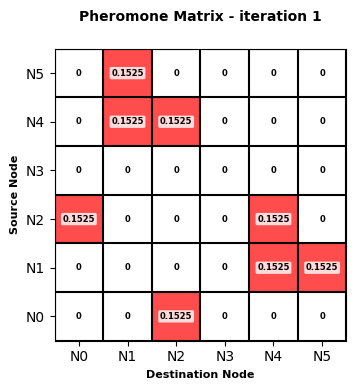

NEW BEST SOLUTION FOUND:
Best solution proposed (Iter. 2):  [0, 1, 4, 2, 3]
Solution vector X no. 2 generated:  [1. 1. 1. 1.]
Fitness of new best solution (Iter. 2):  -0.508


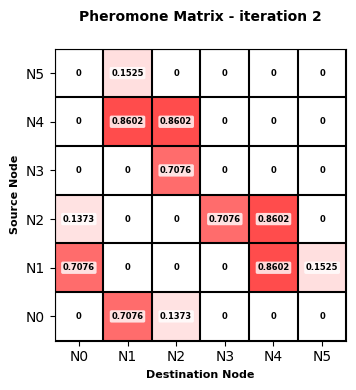

NEW BEST SOLUTION FOUND:
Best solution proposed (Iter. 5):  [0, 1, 3, 4, 5]
Solution vector X no. 5 generated:  [1. 0. 1. 1.]
Fitness of new best solution (Iter. 5):  0.23000000000000004


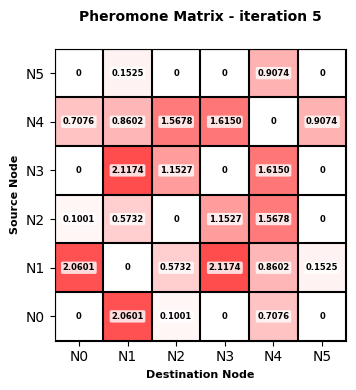

NEW BEST SOLUTION FOUND:
Best solution proposed (Iter. 16):  [0, 3, 5]
Solution vector X no. 16 generated:  [0. 0. 1. 0.]
Fitness of new best solution (Iter. 16):  0.394


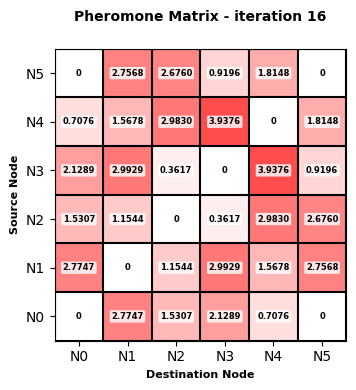

--------------------------------
MAXIMUM NUMBER OF ITERATIONS (40) REACHED WITHOUT CONVERGENCE.
 Convergence loop interrupted at 17 iterations

Best solution found after 40 iterations:
Best path: [0, 3, 5]
Best solution vector X: [0. 0. 1. 0.]
Fitness of best solution: 0.394


In [11]:
best_X, best_solution, best_real_fitness, iter_num, converged, tau = single_simulation(
    M,
    n,
    tau,
    beta_O,
    rho,
    maxIter,
    converCondition,
    optimization_mode,
    plot_best=True
    )

Final pheromone matrix:


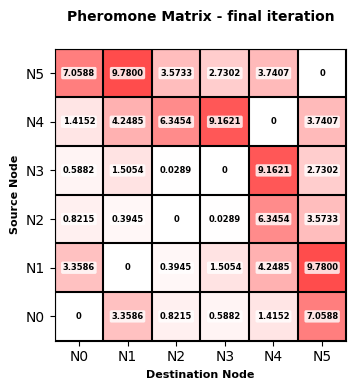

BEST SOLUTION FOUND!
Path (nodes visited): [0, 3, 5]
Solution vector X: [0. 0. 1. 0.]
Fitness of best solution: 0.394
Theoretical fitness of known solution: [0. 1. 1. 0.] 0.45100000000000007


In [12]:
print("Final pheromone matrix:")
plot_pheromone_matrix(tau, title="Pheromone Matrix - final iteration")

print("BEST SOLUTION FOUND!")
print("Path (nodes visited):", best_solution)

print("Solution vector X:", best_X)
print("Fitness of best solution:", best_real_fitness)

# X_th = np.array([1, 0, 1, 1]) # Known solution
print(f"Theoretical fitness of known solution: {X_th}", X_th @ M @ X_th.T)

### **Multiple runs**

In [47]:
multiple_runs(M, X_th, n_runs=100, verbose=True)

Iteraton number:  0
Best solution vector X found:  [0. 1. 0. 0.]
Fitness of best solution found:  0.167
Number of iterations until convergence:  40
Iteraton number:  1
Best solution vector X found:  [0. 1. 1. 0.]
Fitness of best solution found:  0.45100000000000007
Number of iterations until convergence:  24
Iteraton number:  2
Best solution vector X found:  [0. 0. 0. 1.]
Fitness of best solution found:  0.104
Number of iterations until convergence:  20
Iteraton number:  3
Best solution vector X found:  [0. 1. 1. 0.]
Fitness of best solution found:  0.45100000000000007
Number of iterations until convergence:  25
Iteraton number:  4
Best solution vector X found:  [0. 0. 1. 1.]
Fitness of best solution found:  0.437
Number of iterations until convergence:  40
Iteraton number:  5
Best solution vector X found:  [0. 0. 1. 1.]
Fitness of best solution found:  0.437
Number of iterations until convergence:  31
Iteraton number:  6
Best solution vector X found:  [0. 1. 1. 0.]
Fitness of best sol